In [17]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torch.optim import SGD, Adam
from tqdm import tqdm
from utils import Encoder, Decoder, awgn

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cpu


In [18]:
M = 16  # number of constellation points
flag_train_model = True # True: train model, False: load pre-trained model
Path = "./models/ae_siso_awgn_16qam.pth"
encoder = Encoder([M, 10, 10, 2]).to(device)
decoder = Decoder([2, 20, 20, M]).to(device)

In [19]:
if not flag_train_model:
    # read model if exists else train model
    checkpoint = torch.load(Path, map_location=torch.device('cpu'))
    encoder.load_state_dict(checkpoint["Encoder"])
    decoder.load_state_dict(checkpoint["Decoder"])
    print("Model loaded")

epoch=10000: 100%|██████████| 10000/10000 [30:05<00:00,  5.54it/s] 


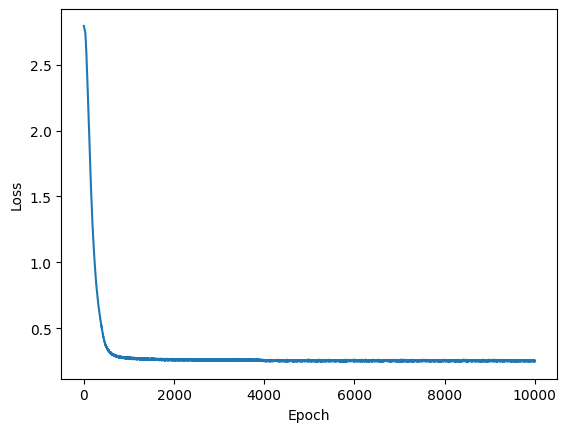

Model saved


In [20]:
if flag_train_model:
    train_snr = 12  # training SNR in dB
    criterion = nn.NLLLoss()  # negative log likelihood loss
    para = list(encoder.parameters()) + list(decoder.parameters())  # get all parameters
    opt = Adam(para, lr=0.001)  # optimizer for training
    loss = []  # store the loss value
    totEpoch = int(1e4)  # total number of epochs
    iteration = tqdm(range(1, totEpoch + 1), desc="loss")

    for iterator in iteration:
        iteration.set_description("epoch={:}".format(iterator))
        messages = torch.randint(0, M, size=(64000,), device=device)  # generate random message ranging from 0 to M-1 shape=(16000,)
        one_hot = F.one_hot(messages, M).float()  # convert to one hot encoding shape=(16000, M)
        tx = encoder(one_hot)

        rx = awgn(tx, train_snr)

        y_pred = decoder(rx)
        cross_entropy = criterion(y_pred, messages)

        opt.zero_grad()
        cross_entropy.backward()
        opt.step()

        loss.append(cross_entropy.item())

    # plot the loss
    plt.figure()
    plt.plot(loss)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    # save the model
    torch.save({
            'Encoder': encoder.state_dict(),
            'Decoder': decoder.state_dict(),
            }, Path)
    print("Model saved")


In [21]:
SNR_dB = np.arange(0, 22, 2)
SER = np.array([])

for snr in SNR_dB:
    num_mess = 6400  # number of messages to test
    minErr = 1e3  # minimum number of errors
    minSym = 1e6  # minimum number of symbols
    maxSym = minErr * 1e4  # maximum number of symbols
    totSym = 0  # total number of symbols
    totErr = 0  # total number of errors
    while totErr < minErr and totSym < maxSym or totSym < minSym:
        messages = torch.randint(0, M, size=(num_mess,)).to(device)
        one_hot = F.one_hot(messages).float()
        tx = encoder(one_hot)
        rx = awgn(tx, snr)
        rx_constant = (
            rx.clone().detach().requires_grad_(False)
        )  # no gradients in the channel model

        y_pred = decoder(rx_constant)

        m_hat = torch.argmax(y_pred, -1)

        err = torch.sum(torch.not_equal(messages, m_hat)).to("cpu").detach().numpy()

        totErr += err
        totSym += num_mess
    SER = np.append(SER, totErr / totSym)

In [22]:
from utils import ser_mqam_awgn

SER_theory = ser_mqam_awgn(M, SNR_dB)

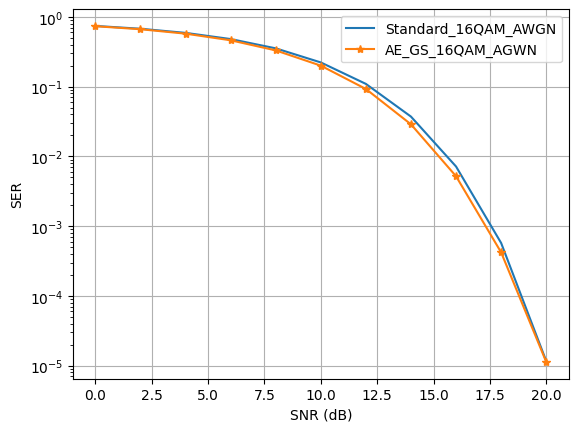

In [23]:
# plot the SER-SNR curve
plt.figure()
plt.xlabel("SNR (dB)")
plt.ylabel("SER")
plt.semilogy(SNR_dB, SER_theory, label="Standard_16QAM_AWGN")
plt.semilogy(SNR_dB, SER, "-*", label="AE_GS_{}QAM_AGWN".format(M))
plt.legend()
plt.grid(True)

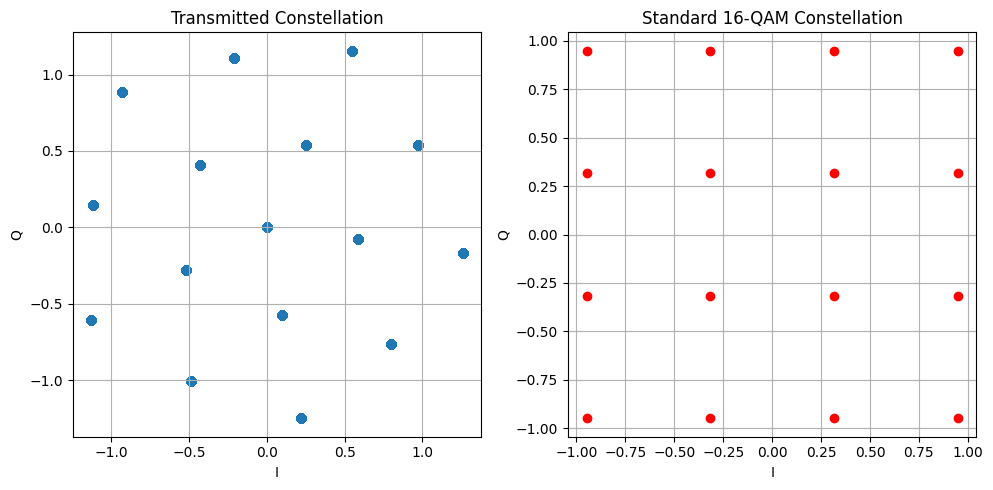

In [24]:
# Generate transmitted symbols using the encoder
num_mess = 6400  # number of messages to test
messages = torch.randint(0, M, size=(num_mess,)).to(device)
one_hot = F.one_hot(messages).float()
tx = encoder(one_hot)
tx = tx.to("cpu").detach().numpy()

# Define the coordinates for 16-QAM constellation points
points_I = np.array([1, 1, 1, 1, -1, -1, -1, -1, 3, 3, 3, 3, -3, -3, -3, -3]) / np.sqrt(10)
points_Q = np.array([3, 1, -1, -3, 3, 1, -1, -3, 3, 1, -1, -3, 3, 1, -1, -3]) / np.sqrt(10)

# Plot both constellations
plt.figure(figsize=(10, 5))

# Plot transmitted symbols
plt.subplot(1, 2, 1)
plt.scatter(tx[:, 0], tx[:, 1])
plt.xlabel("I")
plt.ylabel("Q")
plt.title("Transmitted Constellation")
plt.grid(True)

# Plot standard 16-QAM constellation
plt.subplot(1, 2, 2)
plt.scatter(points_I, points_Q, c="r")
plt.xlabel("I")
plt.ylabel("Q")
plt.title("Standard 16-QAM Constellation")
plt.grid(True)

plt.tight_layout()
plt.show()